# Content

In [203]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.discrete.discrete_model import Logit, LogitResults
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score, make_scorer

In [204]:
data = pd.read_csv('../data/processed/training_data.csv')
data.head()

,price_band,rating_mult,sponsored_option,position_cat_stand,prime_option,subcategory
0,True,49.0,True,-0.756513,True,Boxing Training Gloves
1,True,46.0,True,-0.740763,True,Boxing Gloves
2,True,49.0,True,-0.738252,True,Boxing Gloves
3,True,47.0,True,-0.749363,True,Boxing Training Gloves
4,True,46.0,False,-0.758141,True,Boxing Training Gloves


We will consider just the products in the three main categories: "Boxing Training Gloves", "Boxing Fight Gloves", "Training Gloves". The other categories usually correspond to products that are not boxing gloves, for example, MMA gloves or boxing bandages.

In [205]:
main_cat = data['subcategory'].value_counts()[:3].index.tolist()
data = data[data['subcategory'].isin(main_cat)]

In [206]:
features = ['price_band', 'position_cat_stand', 'rating_mult']

X = data.dropna(how='any')[features].astype(float)
y = data.dropna(how='any')['prime_option']
cv=5  #folds in cross-validation

# Benchmark model: Logistic Regression

As a benchmark model, we will consider the Logistic Regression, particularly the sigmoid kernel (Logit). As a scoring metric, we will use the accuracy as usually. We will discuss later other metrics.

In [207]:
Logit_sm = Logit(endog=np.asarray(y), exog=X).fit()
Logit_sm.summary()

Optimization terminated successfully.
         Current function value: 0.364825
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  254
Model:                          Logit   Df Residuals:                      251
Method:                           MLE   Df Model:                            2
Date:                Sat, 20 Feb 2021   Pseudo R-squ.:                  0.4731
Time:                        22:41:32   Log-Likelihood:                -92.666
converged:                       True   LL-Null:                       -175.86
Covariance Type:            nonrobust   LLR p-value:                 7.380e-37
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
price_band             3.9740      0.412      9.635      0.000       3.166       4.782
position_cat_stand    -1.2465      0.304     -4.097      0.000      -1.843      -0.650
rating_mult           -0.0523      0.007     -7.738      0.000      -0.066      -0.039
======================================================================================
"""

We can see that the LLR p-value is low enough to assume that the features explain the target feature better than a constant model. The Pseudo R-squared is not too much high but enough to consider the model as acceptable if we consider that our sample is very small.

In general, the marginal p-values are zero, but the sponsored_option feature has 0.121 as pvalue. It is high in order to exclude the feature at 95% of confidence, but looking at the other pvalues, if we consider a pair of features, the joint p-value would be null, so this feature will remain in the model.

We could interpret the model as follows:
1. If a product price is in [20, inf], then it is more likely to sell with the prime option.
2. The higher the position in the category rank is, the less likely they to sell with the prime option.
3. The higher the rating is, the less likely to sell with the prime option.

## Diagnostic

We will compute the accuracy over the whole data, perform a cross validation using the recall as a scoring metric, the confussion matrix and a built-in classification report provided by sklearn.

In [208]:
LR = LogisticRegression()
cv_result = cross_validate(LR, X, y,
                           cv=cv, return_train_score=True)

Text(0.5, 1.0, 'Cross validation result')

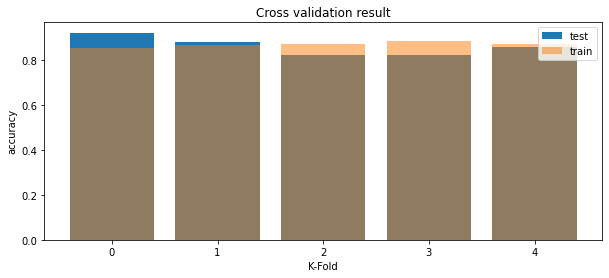

In [209]:
plt.figure(figsize=(10,4))
plt.bar(range(0,cv), cv_result['test_score'])
plt.bar(range(0,cv), cv_result['train_score'], alpha=.5)
plt.legend(['test', 'train'], loc='upper right')
plt.xlabel('K-Fold')
plt.ylabel('accuracy')
plt.title('Cross validation result')

We can see that the model does not seem to depend on the sample because the scores look similar in both training and test sets, so there is no strong evidence of overfitting.

In [210]:
print('\n Confussion Matrix \n\n', pd.crosstab(y, pd.Series(y_pred, name='pred')))
print('\nClassification Report\n')
print(classification_report(y, y_pred))


 Confussion Matrix 

 pred          False  True 
prime_option              
False           117     15
True             19    103

Classification Report

              precision    recall  f1-score   support

       False       0.86      0.89      0.87       132
        True       0.87      0.84      0.86       122

    accuracy                           0.87       254
   macro avg       0.87      0.87      0.87       254
weighted avg       0.87      0.87      0.87       254



We can see that 87% of Prime products have been well classified, and 86% of no prime products have been well classified. The errors are not unbalanced because the recalls are similar. Let's see how the model performs in the entire dataset.

In [211]:
y_pred = Logit_sm.predict(X).apply(lambda x: True if x>=0.5 else False)
print('accuracy: ', LR.fit(X,y).score(X,y),
      '\ncv accuracy mean (testing): ', np.mean(cv_result['test_score']))

accuracy:  0.8700787401574803 
cv accuracy mean (testing):  0.8621960784313725


We can see that the accuracy is around 86%, and the accuracy over unseen observations during the cross-validation is close to 0.86% too.

# Conclusion

In overall the Logistic Regression can classify Boxing Gloves products into Prime or not Prime option in the Amazon's shop with an accuracy and recall around 86% which means that 86 out 100 times, it will lead us to the correct decission.

# Model's Threshold discussion

Let's say that the Amazon Prime option has a cost of $c > 0$ by month, and the opportunity cost by purchase (the customer does not buy the product because it is not in Prime option) is $c'>0$. How could we say in order to the costs if the model still being acceptable?

We should consider three cases:

1. $c'>c$, in this case, the seller would want to sell in Amazon Prime option even the cost of Amazon Prime because the opportunity cost of no selling is greater than the Amazon subscription. In this case, we should adjust the threshold close to 1 in order to ensure that the False Negatives (products that are wrong classified in no Prime) are as less as possible.
2. $c'<c$, this case is the opposite of the above one.
3. $c' \approx c$, in this case, does not matter the costs, and the threshold is set up at 0.5 by definition, which usually means balanced classification errors.

# References

[1] Prime option subscription information:
https://services.amazon.co.uk/services/sell-online/pricing.html